In [94]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

# Set random seed for reproducibility
np.random.seed(42)

sns.set(style='whitegrid')
%matplotlib inline

In [ ]:
# Load preprocessed data
preprocessed_train = pd.read_csv('../Data/preprocessed_train.csv')
preprocessed_test = pd.read_csv('../Data/preprocessed_test.csv')

# Features and target
X_train = preprocessed_train.drop(columns=['crime_rate_per_100000'])
y_train = preprocessed_train['crime_rate_per_100000']

X_test = preprocessed_test.drop(columns=['crime_rate_per_100000'])
y_test = preprocessed_test['crime_rate_per_100000']

In [96]:
def evaluate_model(model, X_train, y_train, X_test, y_test, calculate_mape=True):
    """
    Evaluates a regression model on both log-transformed and original scales.
    """
    # Predictions on training data
    y_train_pred = model.predict(X_train)

    # Predictions on test data
    y_test_pred = model.predict(X_test)

    # Metrics on log-transformed scale
    mse_train_log = mean_squared_error(y_train, y_train_pred)
    mae_train_log = mean_absolute_error(y_train, y_train_pred)
    r2_train_log = r2_score(y_train, y_train_pred)

    mse_test_log = mean_squared_error(y_test, y_test_pred)
    mae_test_log = mean_absolute_error(y_test, y_test_pred)
    r2_test_log = r2_score(y_test, y_test_pred)

    # Inverse transform the target variables and predictions to original scale
    y_train_inv = np.expm1(y_train)
    y_train_pred_inv = np.expm1(y_train_pred)
    y_test_inv = np.expm1(y_test)
    y_test_pred_inv = np.expm1(y_test_pred)

    # Metrics on original scale
    mse_train_orig = mean_squared_error(y_train_inv, y_train_pred_inv)
    mae_train_orig = mean_absolute_error(y_train_inv, y_train_pred_inv)
    r2_train_orig = r2_score(y_train_inv, y_train_pred_inv)

    mse_test_orig = mean_squared_error(y_test_inv, y_test_pred_inv)
    mae_test_orig = mean_absolute_error(y_test_inv, y_test_pred_inv)
    r2_test_orig = r2_score(y_test_inv, y_test_pred_inv)

    metrics = {
        # Metrics on log-transformed scale
        'Train_MSE': mse_train_log,
        'Test_MSE': mse_test_log,
        'Train_R2_Score': r2_train_log,
        'Test_R2_Score': r2_test_log,

        # Metrics on original scale
       # 'Train_MSE_Orig': mse_train_orig,
       # 'Test_MSE_Orig': mse_test_orig,
       # 'Train_MAE_Orig': mae_train_orig,
       # 'Test_MAE_Orig': mae_test_orig,
       # 'Train_R2_Score_Orig': r2_train_orig,
       # 'Test_R2_Score_Orig': r2_test_orig,

    }

    if calculate_mape:
        # Exclude zero values for MAPE calculation
        mask_test = y_test_inv != 0
        if np.any(mask_test):
            mape_test = np.mean(np.abs((y_test_inv[mask_test] - y_test_pred_inv[mask_test]) / y_test_inv[mask_test])) * 100
            metrics.update({'Test_MAPE': mape_test})
        else:
            metrics.update({'Test_MAPE': np.nan})

        mask_train = y_train_inv != 0
        if np.any(mask_train):
            mape_train = np.mean(np.abs((y_train_inv[mask_train] - y_train_pred_inv[mask_train]) / y_train_inv[mask_train])) * 100
            metrics.update({'Train_MAPE': mape_train})
        else:
            metrics.update({'Train_MAPE': np.nan})

    return metrics

# Linear Regression

In [97]:
# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model on the training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [98]:
# Evaluate Linear Regression
linear_metrics = evaluate_model(linear_model, X_train, y_train, X_test, y_test)

# Display metrics
print("Linear Regression Metrics:")
for key, value in linear_metrics.items():
    print(f"{key}: {value:.4f}")

Linear Regression Metrics:
Train_MSE: 0.8717
Test_MSE: 0.9189
Train_R2_Score: 0.5208
Test_R2_Score: 0.5489
Test_MAPE: 51.2186
Train_MAPE: 57.2775


# Ridge Regression

In [99]:
# Define hyperparameter grid for Ridge Regression
ridge_param_grid = {'alpha': 10**np.linspace(4, -6, 101)}

# Initialize Ridge regression model
ridge = Ridge()

# Set up GridSearchCV for Ridge Regression
ridge_cv = GridSearchCV(
    ridge,
    ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the model to find the best alpha
ridge_cv.fit(X_train, y_train)

# Best alpha
best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")

# Train Ridge model with the best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

# Evaluate Ridge Regression
ridge_metrics = evaluate_model(ridge_model, X_train, y_train, X_test, y_test)

# Display metrics
print("Ridge Regression Metrics:")
for key, value in ridge_metrics.items():
    print(f"{key}: {value:.4f}")

Best alpha for Ridge Regression: 2.5118864315095797
Ridge Regression Metrics:
Train_MSE: 0.8718
Test_MSE: 0.9214
Train_R2_Score: 0.5207
Test_R2_Score: 0.5476
Test_MAPE: 51.0438
Train_MAPE: 57.0651


# Lasso Regression

In [100]:
# Define hyperparameter grid for Lasso Regression
lasso_param_grid = {'alpha': 10**np.linspace(4, -6, 101)}

# Initialize Lasso regression model
lasso = Lasso(max_iter=10000)

# Set up GridSearchCV for Lasso Regression
lasso_cv = GridSearchCV(
    lasso,
    lasso_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the model to find the best alpha
lasso_cv.fit(X_train, y_train)

# Best alpha
best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso Regression: {best_alpha_lasso}")

# Train Lasso model with the best alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Evaluate Lasso Regression
lasso_metrics = evaluate_model(lasso_model, X_train, y_train, X_test, y_test)

# Display metrics
print("Lasso Regression Metrics:")
for key, value in lasso_metrics.items():
    print(f"{key}: {value:.4f}")

Best alpha for Lasso Regression: 0.0012589254117941662
Lasso Regression Metrics:
Train_MSE: 0.8717
Test_MSE: 0.9188
Train_R2_Score: 0.5207
Test_R2_Score: 0.5489
Test_MAPE: 51.1588
Train_MAPE: 57.1658


#### Elastic Net Regression

In [101]:
# Define hyperparameter grid for Elastic Net Regression
enet_param_grid = {
    'alpha': 10**np.linspace(4, -6, 101),
    'l1_ratio': np.linspace(0.1, 0.9, 9)
}

# Initialize Elastic Net model
elasticnet = ElasticNet(max_iter=10000)

# Set up GridSearchCV for Elastic Net Regression
enet_cv = GridSearchCV(
    elasticnet,
    enet_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the model to find the best hyperparameters
enet_cv.fit(X_train, y_train)

# Best hyperparameters
best_alpha_enet = enet_cv.best_params_['alpha']
best_l1_ratio_enet = enet_cv.best_params_['l1_ratio']
print(f"Best alpha for Elastic Net: {best_alpha_enet}")
print(f"Best l1_ratio for Elastic Net: {best_l1_ratio_enet}")

# Train Elastic Net model with the best hyperparameters
elasticnet_model = ElasticNet(alpha=best_alpha_enet, l1_ratio=best_l1_ratio_enet, max_iter=10000)
elasticnet_model.fit(X_train, y_train)

# Evaluate Elastic Net Regression
enet_metrics = evaluate_model(elasticnet_model, X_train, y_train, X_test, y_test)

# Display metrics
print("Elastic Net Regression Metrics:")
for key, value in enet_metrics.items():
    print(f"{key}: {value:.4f}")

Best alpha for Elastic Net: 0.0031622776601683794
Best l1_ratio for Elastic Net: 0.1
Elastic Net Regression Metrics:
Train_MSE: 0.8719
Test_MSE: 0.9218
Train_R2_Score: 0.5206
Test_R2_Score: 0.5474
Test_MAPE: 51.0050
Train_MAPE: 57.0093


#Tree-Based Models

#### Random Forest Regressor

In [102]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [200, 400, 600],
    'max_features': ['sqrt', 'log2', 0.33],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Set up RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=50,
    cv=5
    ,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    error_score='raise'
)

# Fit the model
rf_random_search.fit(X_train, y_train)

# Best parameters
best_rf_params = rf_random_search.best_params_
print("Best parameters for Random Forest:", best_rf_params)

# Best estimator
best_rf = rf_random_search.best_estimator_

# Evaluate Random Forest
rf_metrics = evaluate_model(best_rf, X_train, y_train, X_test, y_test)

# Display metrics
print("Random Forest Metrics:")
for key, value in rf_metrics.items():
    print(f"{key}: {value:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Random Forest Metrics:
Train_MSE: 0.2528
Test_MSE: 0.7208
Train_R2_Score: 0.8610
Test_R2_Score: 0.6461
Test_MAPE: 51.7171
Train_MAPE: 30.4345


### Gradient Boosting Regressor

In [103]:
# Initialize Gradient Boosting model
gb = GradientBoostingRegressor(random_state=42)

# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', 0.33],
    'min_samples_split': [2, 5, 10]
}

# Set up RandomizedSearchCV for Gradient Boosting
gb_random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    error_score='raise'
)

# Fit the model
gb_random_search.fit(X_train, y_train)

# Best parameters
best_gb_params = gb_random_search.best_params_
print("Best parameters for Gradient Boosting:", best_gb_params)

# Best estimator
best_gb = gb_random_search.best_estimator_

# Evaluate Gradient Boosting
gb_metrics = evaluate_model(best_gb, X_train, y_train, X_test, y_test)

# Display metrics
print("Gradient Boosting Metrics:")
for key, value in gb_metrics.items():
    print(f"{key}: {value:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Gradient Boosting: {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.05}
Gradient Boosting Metrics:
Train_MSE: 0.4503
Test_MSE: 0.7935
Train_R2_Score: 0.7524
Test_R2_Score: 0.6104
Test_MAPE: 55.5740
Train_MAPE: 46.7728


In [104]:
# Create a DataFrame to compare metrics
model_comparison = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Ridge Regression',
        'Lasso Regression',
        'Elastic Net Regression',
        'Random Forest',
        'Gradient Boosting'
    ],
    'Train_MSE': [
        linear_metrics['Train_MSE'],
        ridge_metrics['Train_MSE'],
        lasso_metrics['Train_MSE'],
        enet_metrics['Train_MSE'],
        rf_metrics['Train_MSE'],
        gb_metrics['Train_MSE']
    ],
    'Test_MSE': [
        linear_metrics['Test_MSE'],
        ridge_metrics['Test_MSE'],
        lasso_metrics['Test_MSE'],
        enet_metrics['Test_MSE'],
        rf_metrics['Test_MSE'],
        gb_metrics['Test_MSE']
    ],
    'Train_R2_Score': [
        linear_metrics['Train_R2_Score'],
        ridge_metrics['Train_R2_Score'],
        lasso_metrics['Train_R2_Score'],
        enet_metrics['Train_R2_Score'],
        rf_metrics['Train_R2_Score'],
        gb_metrics['Train_R2_Score']
    ],
    'Test_R2_Score': [
        linear_metrics['Test_R2_Score'],
        ridge_metrics['Test_R2_Score'],
        lasso_metrics['Test_R2_Score'],
        enet_metrics['Test_R2_Score'],
        rf_metrics['Test_R2_Score'],
        gb_metrics['Test_R2_Score']
    ],
    'Test_MAPE': [
        linear_metrics['Test_MAPE'],
        ridge_metrics['Test_MAPE'],
        lasso_metrics['Test_MAPE'],
        enet_metrics['Test_MAPE'],
        rf_metrics['Test_MAPE'],
        gb_metrics['Test_MAPE']
    ]
})

print("Model Comparison:")
display(model_comparison)

Model Comparison:


,Model,Train_MSE,Test_MSE,Train_R2_Score,Test_R2_Score,Test_MAPE
0,Linear Regression,0.871653,0.918869,0.520761,0.548859,51.218577
1,Ridge Regression,0.871787,0.921394,0.520687,0.547619,51.043754
2,Lasso Regression,0.871711,0.918836,0.520728,0.548875,51.158786
3,Elastic Net Regression,0.871866,0.921786,0.520643,0.547427,51.005039
4,Random Forest,0.252830,0.720806,0.860993,0.646103,51.717087
5,Gradient Boosting,0.450339,0.793542,0.752401,0.610391,55.573988


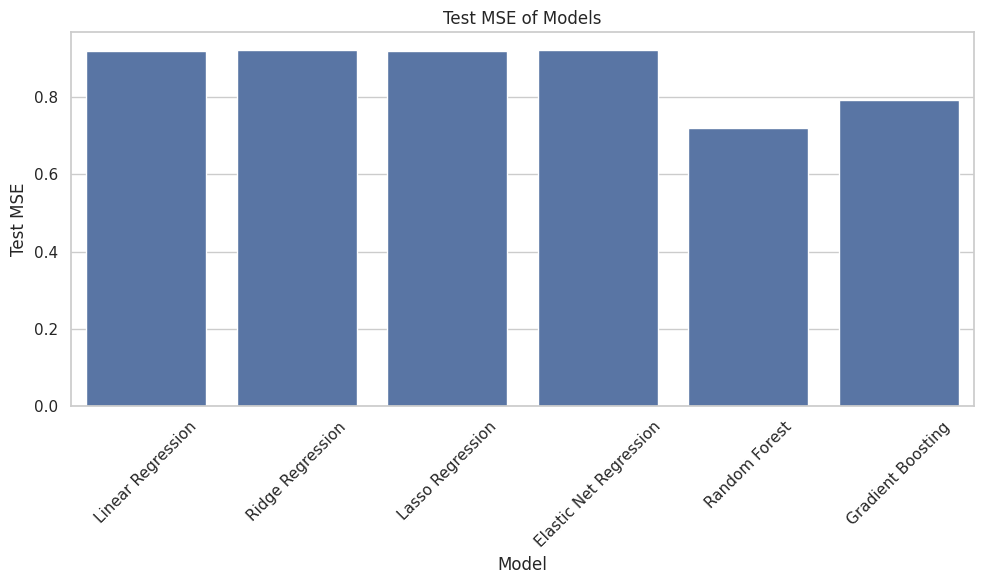

In [109]:
# Visualize Test MSE of All Models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test_MSE', data=model_comparison)
plt.title('Test MSE of Models')
plt.ylabel('Test MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [106]:
# Install SHAP if not already installed
!pip install shap

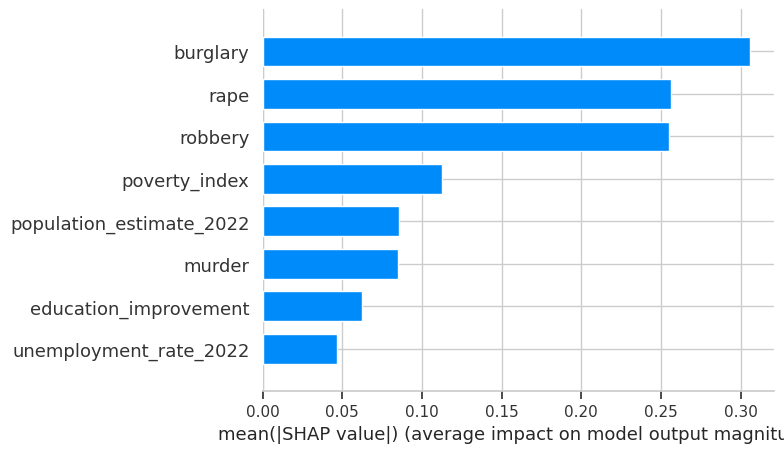

In [110]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [111]:
joblib.dump(best_rf, 'best_random_forest_model.joblib')

['best_random_forest_model.joblib']